# Calibration-curve

## \# Function to calculate calibration parameters

In [ ]:
library(ggplot2)
library(readxl)
library(scales)
library(grid)
library(gridExtra)
library(dplyr)


## \# Function to calculate calibration parameters

In [ ]:
library(ggplot2)
library(readxl)
library(scales)
library(grid)
library(gridExtra)
library(dplyr)


calculate_calibration_parameters <- function(row) {
  concentrations <- c()
  areas <- c()
  
  initial_concentration <- row[["Initial concentration"]]
  injection_columns <- c(names(row)[grep("^0_0", names(row))], 
                         unlist(lapply(1:7, function(i) paste0(i, "_", c(5, 1)))))
  
  for (col in injection_columns) {
    if (!is.na(row[[col]])) {
      if (grepl("^0_0", col)) {
        effective_concentration <- 0
      } else {
        volume <- as.numeric(unlist(strsplit(col, "_"))[2])
        factor <- 1 / (2 ^ (as.numeric(unlist(strsplit(col, "_"))[1]) - 1))
        concentration <- initial_concentration * factor
        effective_concentration <- concentration * volume
      }
      area <- row[[col]]
      
      concentrations <- c(concentrations, effective_concentration)
      areas <- c(areas, area)
    }
  }
  
  data <- data.frame(concentrations = concentrations, areas = areas)
  model <- lm(areas ~ concentrations, data = data)
  slope <- coef(model)[2]
  intercept <- coef(model)[1]
  r_squared <- summary(model)$r.squared
  
  # Find LOD (first non-zero concentration)
  non_zero_concentrations <- concentrations[concentrations > 0 & areas > 0]
  LOD <- ifelse(length(non_zero_concentrations) > 0, min(non_zero_concentrations), NA)
  
  # Find LOQ (lowest concentration that's at least 3 times LOD)
  LOQ <- ifelse(!is.na(LOD), min(concentrations[concentrations >= 3 * LOD & areas > 0]), NA)
  
  # If no concentration meets the 3*LOD criterion, use the highest calibrator
  if (is.na(LOQ)) {
    LOQ <- max(concentrations)
  }
  
  return(list(
    slope = slope,
    intercept = intercept,
    LOD = LOD,
    LOQ = LOQ,
    r_squared = r_squared,
    concentrations = concentrations,
    areas = areas
  ))
}

## Load your data from an Excel file

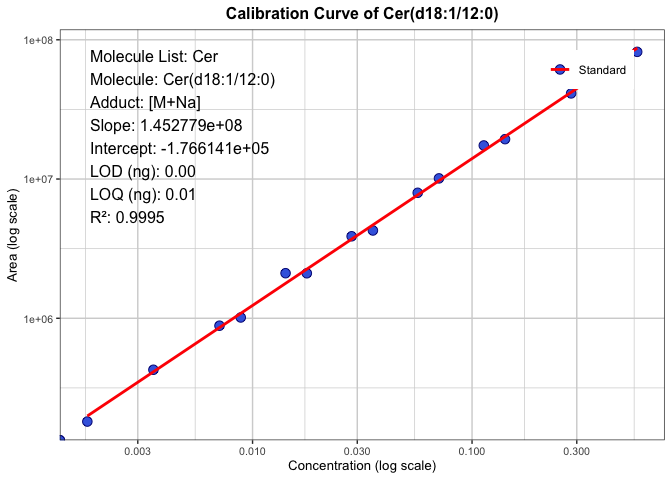

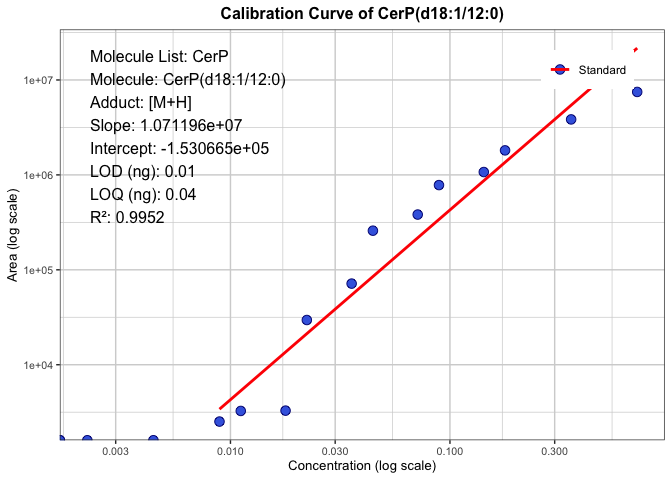

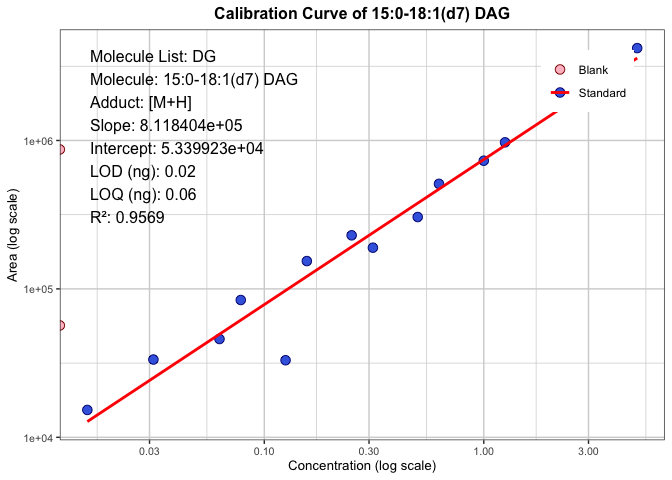

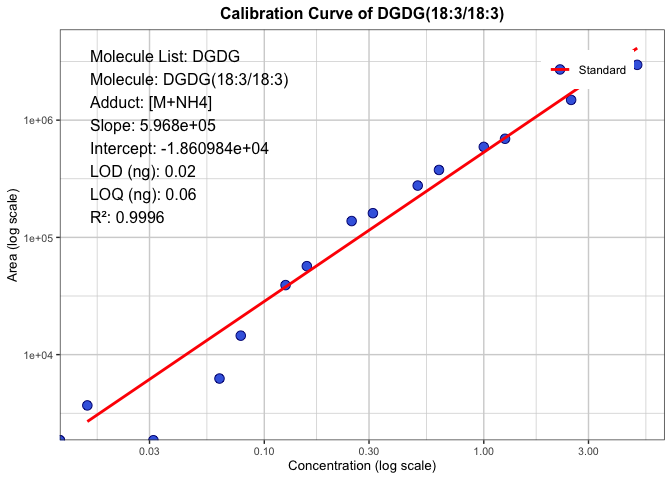

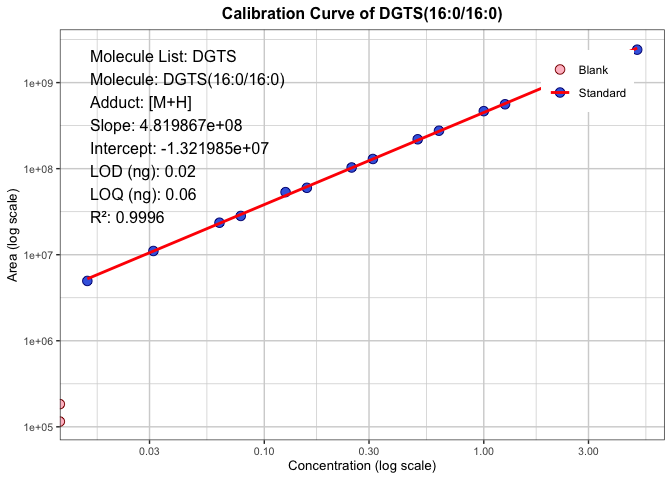

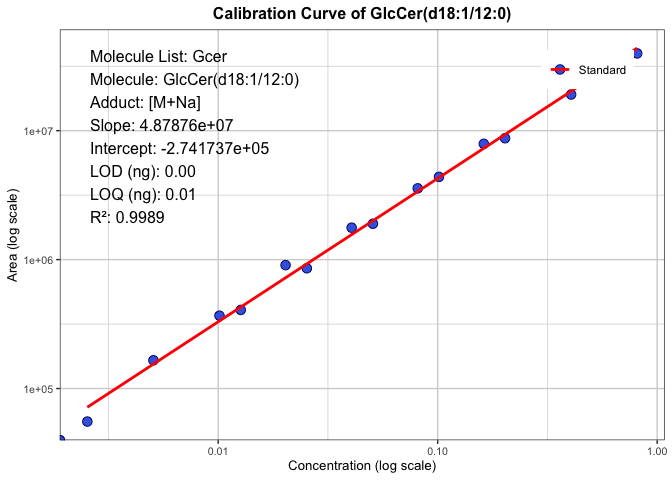

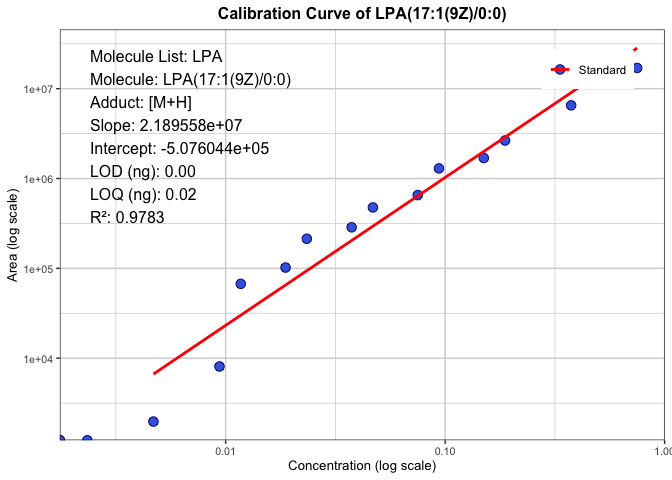

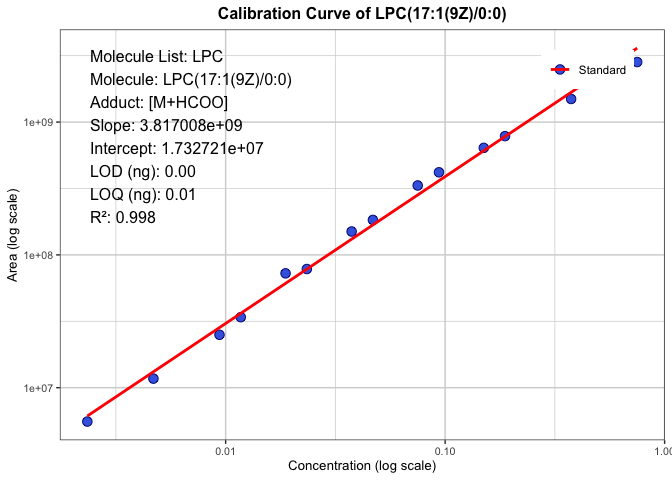

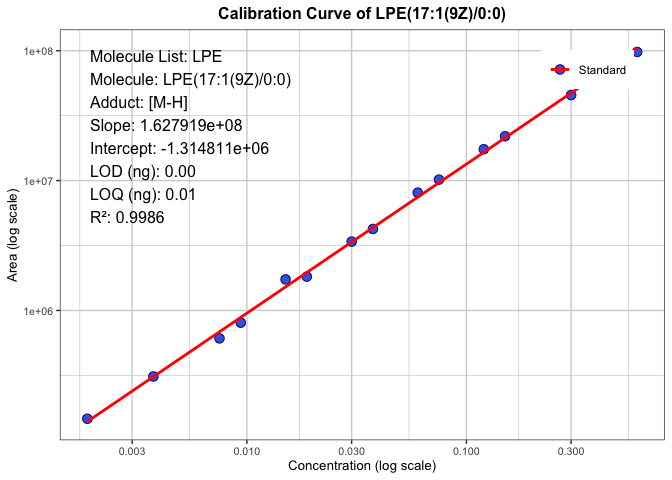

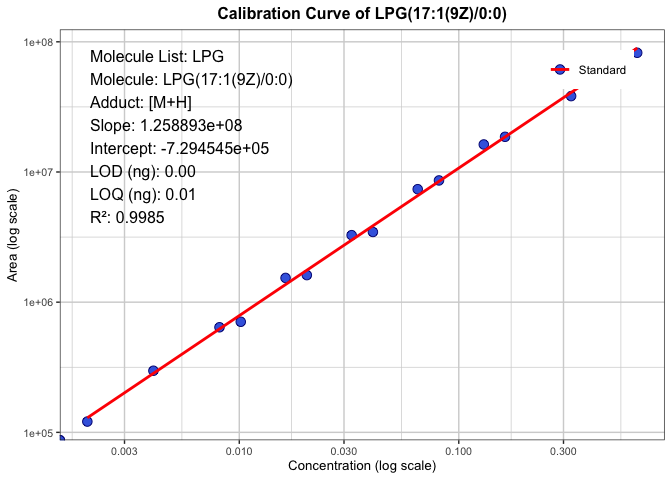

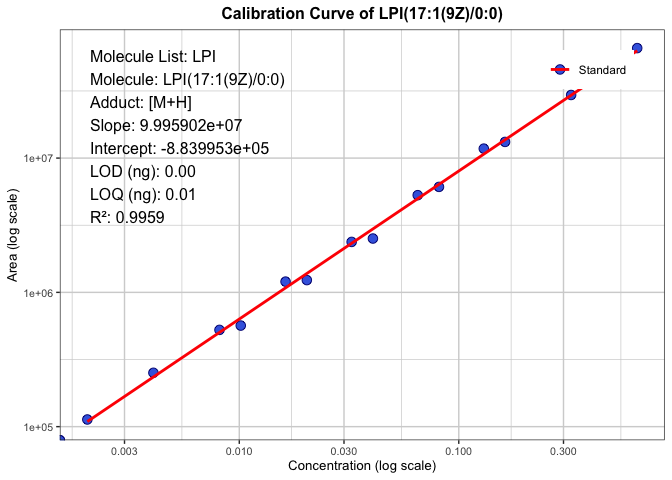

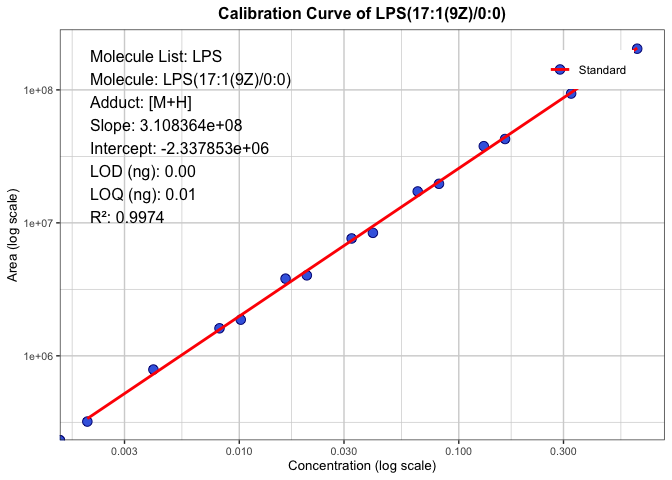

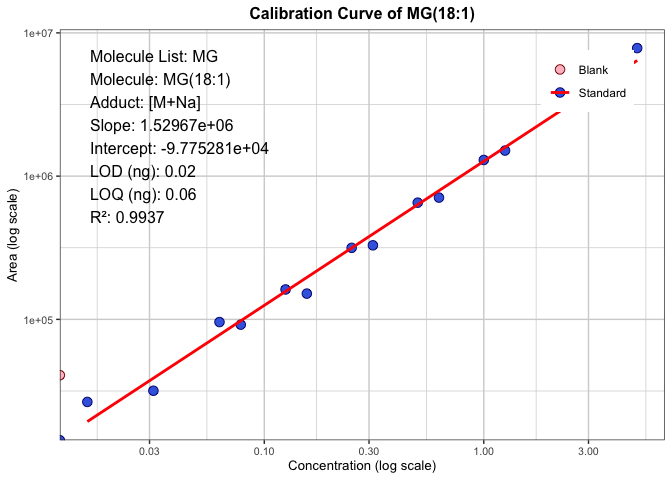

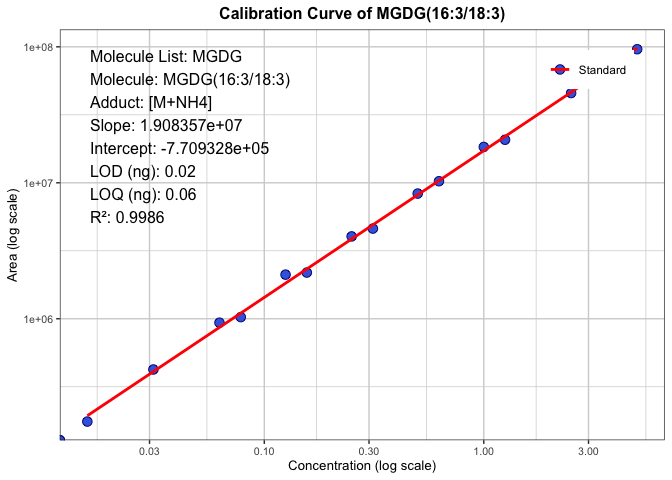

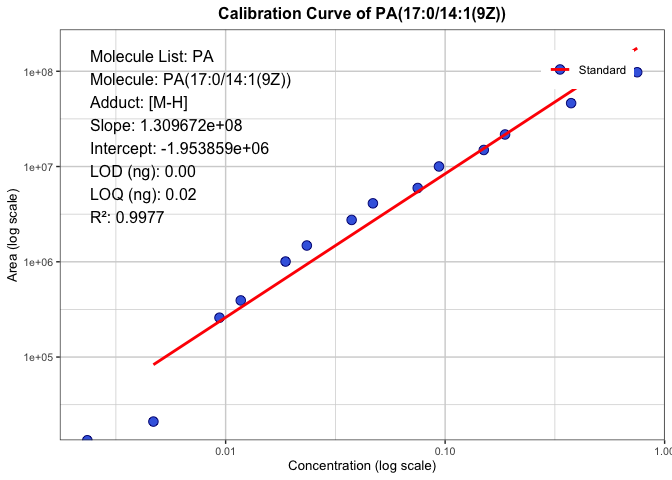

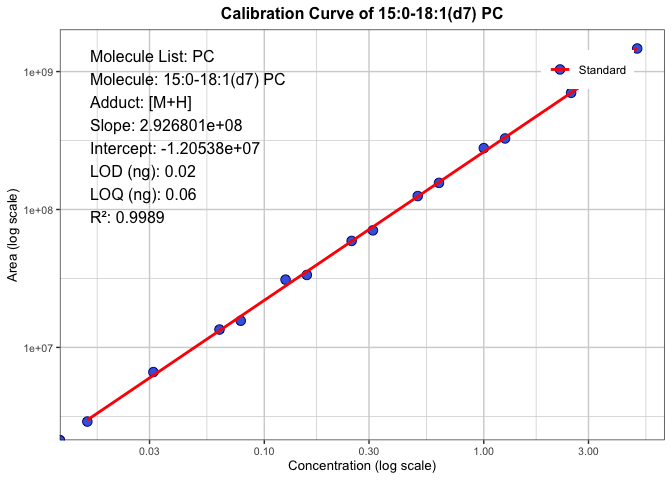

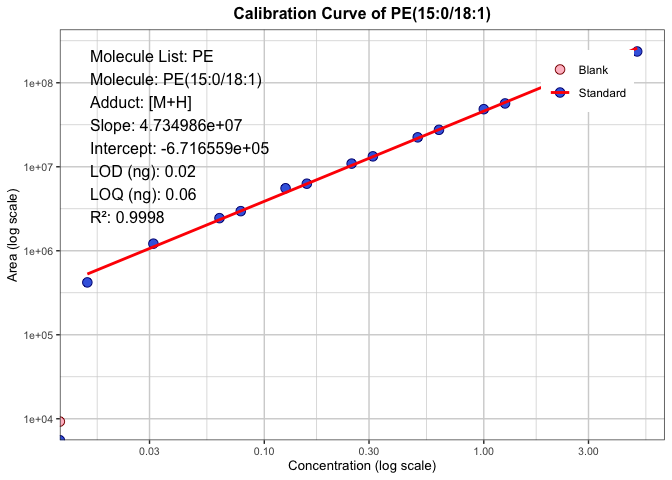

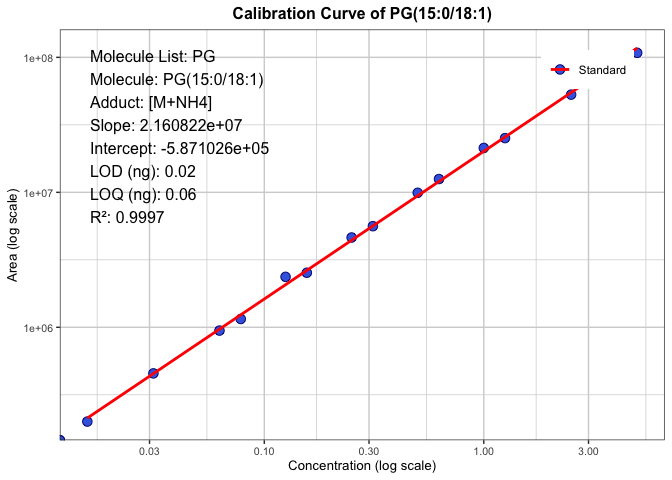

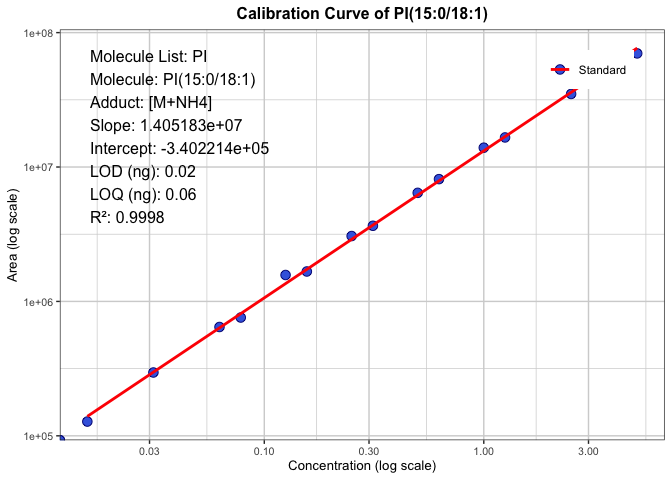

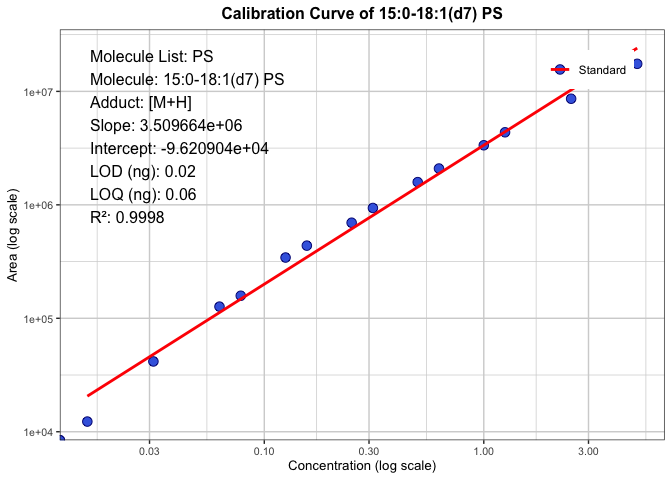

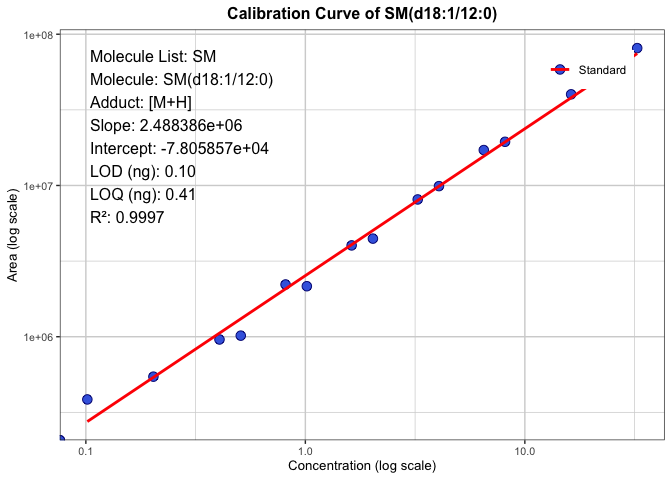

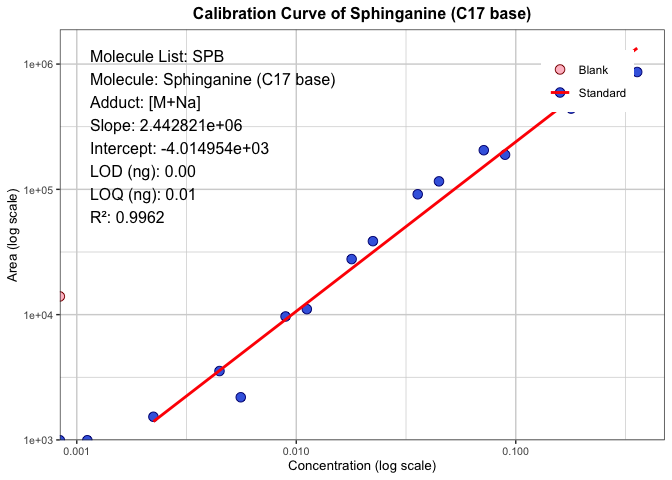

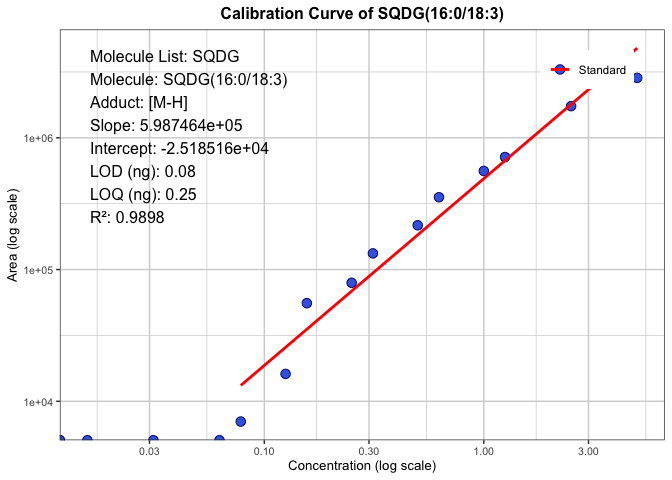

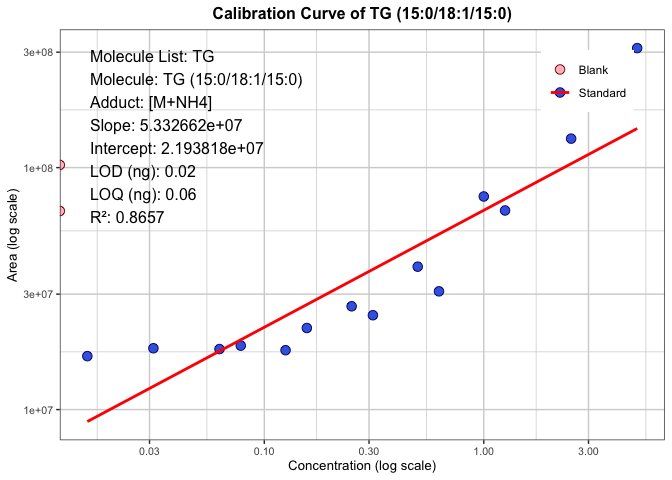

In [ ]:
data <- read_excel("CAL.xlsx", sheet = "Sheet1")

# Filter to keep only the rows with the best R² value for each Molecule List
best_r2_rows <- data %>%
  group_by(`Molecule List`) %>%
  slice(which.max(R.))

# Create a list to store all plots
plot_list <- list()

# Loop through the filtered rows
for (i in 1:nrow(best_r2_rows)) {
  row <- best_r2_rows[i, ]
  result <- calculate_calibration_parameters(row)
  molecule_list <- row[["Molecule List"]]
  molecule <- row[["Molecule"]]
  adduct <- row[["Precursor Adduct"]]
  
  # Create plot data and add a column to distinguish blanks from standards
  plot_data <- data.frame(
    concentrations = result$concentrations,
    areas = result$areas,
    type = ifelse(result$concentrations == 0 & result$areas > 0, "Blank", "Standard")
  )
  
  # Create the annotation text
  annotation_text <- paste(
    "Molecule List:", molecule_list,
    "\nMolecule:", molecule,
    "\nAdduct:", adduct,
    "\nSlope:", format(result$slope, scientific = TRUE),
    "\nIntercept:", format(result$intercept, scientific = TRUE),
    "\nLOD (ng):", sprintf("%.2f", result$LOD),
    "\nLOQ (ng):", sprintf("%.2f", result$LOQ),
    "\nR²:", round(result$r_squared, 4)
  )
  
  # Create the plot with log scales
  p <- ggplot(plot_data, aes(x = concentrations, y = areas, color = type, fill = type)) +
    geom_point(size = 3, shape = 21) +
    geom_smooth(data = subset(plot_data, type == "Standard"), 
                method = "lm", se = FALSE, color = "red", size = 1) +
    labs(
      title = paste("Calibration Curve of", molecule),
      x = "Concentration (log scale)",
      y = "Area (log scale)"
    ) +
    scale_x_log10() +
    scale_y_log10(labels = scales::scientific_format(digits = 2)) +
    scale_color_manual(values = c("Standard" = "navy", "Blank" = "darkred")) +
    scale_fill_manual(values = c("Standard" = "royalblue", "Blank" = "pink")) +
    theme_bw() +
    theme(
      plot.title = element_text(hjust = 0.5, size = 12, face = "bold"),
      axis.title = element_text(size = 10),
      axis.text = element_text(size = 8),
      panel.grid.major = element_line(color = "lightgray"),
      panel.grid.minor = element_line(color = "lightgray"),
      legend.position = c(0.95, 0.95),
      legend.justification = c("right", "top"),
      legend.box.just = "right",
      legend.margin = margin(6, 6, 6, 6),
      legend.title = element_blank()
    ) +
    annotation_custom(
      grob = textGrob(
        annotation_text,
        x = unit(0.05, "npc"), 
        y = unit(0.95, "npc"),
        just = c("left", "top"),
        gp = gpar(fontsize = 12)
      )
    )
  
  # Add the plot to the list
  plot_list[[i]] <- p
}

# Display all plots in the R console
for (p in plot_list) {
  print(p)
}